In [70]:
import csv
import os
import pandas as pd
import sys
import numpy as np
from string import punctuation
import re
punct = punctuation+'«»—…“”*№–'
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()
from collections import Counter

### Задание 1: описательные статистики

In [40]:
df = pd.read_csv('vk_texts_with_sources.csv', sep= ',', index_col = ['Unnamed: 0'])

df.dropna(inplace=True) # избавляемся от пустых строк
df.reset_index(drop=True, inplace=True) # переназначим индексы
df.head()

,text,source
0,Начальник Главного оперативного управления Ген...,mil
1,Артиллерийские подразделения общевойскового об...,mil
2,Подразделения морской пехоты Каспийской флотил...,mil
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil
4,На большом учебно-методическом командирском сб...,mil


In [41]:
df.count()

text      11526
source    11526
dtype: int64

Итак, **количество текстов: 11526** (тот же результат мы бы получили с помощью `count_row = df.shape[0]` (ведь количество текстов равно количеству непустых строк)

In [42]:
df.source.nunique() # количество классов (по источнику)

4

**Количество классов**, как видим, равно **4**

In [43]:
df.groupby('source').count() # количество текстов в каждом из классов

,text
source,
mchsgov,3024
mil,3017
mospolice,2854
russianpost,2631


In [44]:
def brrr(text):
    clean_text = re.sub(r'<br>', ' ', text)
    return clean_text

In [45]:
df['clean_text'] = df['text'].apply(brrr)

df.tail()

,text,source,clean_text
11521,Столичная Госавтоинспекция информирует<br><br>...,mospolice,Столичная Госавтоинспекция информирует Госавт...
11522,Сотрудниками ГУУР МВД России перекрыт один из ...,mospolice,Сотрудниками ГУУР МВД России перекрыт один из ...
11523,Желаем вам хороших выходных в кругу самых близ...,mospolice,Желаем вам хороших выходных в кругу самых близ...
11524,Участковый района Коньково задержал молодого ч...,mospolice,Участковый района Коньково задержал молодого ч...
11525,На Васильевском спуске проходит митинг-концерт...,mospolice,На Васильевском спуске проходит митинг-концерт...


In [46]:
df['symb_len'] = df['clean_text'].str.len() # длина текста в символах

df['symb_len'].mean()

673.1597258372376

**Средняя длина текста в символах: 673**

Теперь токенизируем текст, чтобы было удобно дальше с ним работать (заодно почистим всякие возможные артефакты)

In [56]:
def tokenize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [re.sub(r'br>', '', word) for word in words]
    words = [re.sub(r'<<', ' ', word) for word in words]
    words = [word for word in words if word and word != 'br']
    
    return words

df['tok_text'] = [tokenize(i) for i in df['clean_text']]

df['len_in_words'] = [len(i) for i in df['tok_text']]

df.tail()

,text,source,clean_text,symb_len,tok_text,len_in_words
11521,Столичная Госавтоинспекция информирует<br><br>...,mospolice,Столичная Госавтоинспекция информирует Госавт...,821,"[столичная, госавтоинспекция, информирует, гос...",122
11522,Сотрудниками ГУУР МВД России перекрыт один из ...,mospolice,Сотрудниками ГУУР МВД России перекрыт один из ...,990,"[сотрудниками, гуур, мвд, россии, перекрыт, од...",130
11523,Желаем вам хороших выходных в кругу самых близ...,mospolice,Желаем вам хороших выходных в кругу самых близ...,56,"[желаем, вам, хороших, выходных, в, кругу, сам...",9
11524,Участковый района Коньково задержал молодого ч...,mospolice,Участковый района Коньково задержал молодого ч...,1071,"[участковый, района, коньково, задержал, молод...",146
11525,На Васильевском спуске проходит митинг-концерт...,mospolice,На Васильевском спуске проходит митинг-концерт...,116,"[на, васильевском, спуске, проходит, митинг-ко...",15


In [60]:
print(df['len_in_words'].mean()) #средняя длина текста в словах

84.62406732604546


Или так:

In [61]:
df.len_in_words.describe()

count    11526.000000
mean        84.624067
std         94.286409
min          1.000000
25%         19.000000
50%         62.000000
75%        119.000000
max       1611.000000
Name: len_in_words, dtype: float64

**Средняя длина текста в словах: 84,6**

In [64]:
df['len_in_words'].sum() #количество слов в коллекции

975377

**Количество слов в коллекции: 975377**

Приступаем к лемматизации

In [65]:
def lemmatize(text):
    
    words_lem = [morph.parse(word)[0].normal_form for word in text if word]
    
    return words_lem

In [66]:
df['lemm_text'] = [lemmatize(i) for i in df['tok_text']]

In [68]:
df.head()

,text,source,clean_text,symb_len,tok_text,len_in_words,lemm_text
0,Начальник Главного оперативного управления Ген...,mil,Начальник Главного оперативного управления Ген...,12982,"[начальник, главного, оперативного, управления...",1611,"[начальник, главный, оперативный, управление, ..."
1,Артиллерийские подразделения общевойскового об...,mil,Артиллерийские подразделения общевойскового об...,741,"[артиллерийские, подразделения, общевойскового...",90,"[артиллерийский, подразделение, общевойсковой,..."
2,Подразделения морской пехоты Каспийской флотил...,mil,Подразделения морской пехоты Каспийской флотил...,481,"[подразделения, морской, пехоты, каспийской, ф...",52,"[подразделение, морской, пехота, каспийский, ф..."
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil,Команды на всеармейских этапах конкурсов АрМИ-...,1067,"[команды, на, всеармейских, этапах, конкурсов,...",130,"[команда, на, всеармейский, этап, конкурс, арм..."
4,На большом учебно-методическом командирском сб...,mil,На большом учебно-методическом командирском сб...,701,"[на, большом, учебно-методическом, командирско...",81,"[на, большой, учебно-методический, командирски..."


In [69]:
def count_words(column):

    lst_words = []

    for i in column:
        lst_words.extend(i)
    return lst_words
    
    
len(set(count_words(df['lemm_text']))) #количество уникальных лемм в коллекции

39128

**Количество уникальных лемм в коллекции: 39128**

Теперь будем разбивать датафрейм на датафреймы меньшего размера в зависимости от класса (источника) 

In [71]:
# оставляем только лемматизированные существительные
def lemmatize_noun(text):
    
    words_lem = [morph.parse(word)[0] for word in text if word]
    words_lem = [word.normal_form for word in words_lem if word.tag.POS == 'NOUN']
    
    return words_lem

In [72]:
# разбиваем датафрейм по классу
def splt(i):
    
    mask = df['source'] == i
    df1, df2 = df[mask], df[~mask]
    
    return df1

In [73]:
def count_most_common(column):
    
    lst_noun = []
    
    for i in column:
        lst_noun.extend(i)
    
    return Counter(lst_noun).most_common(10) # в этом задании нужно определить 5 самых частых слов, но мы возьмём 10 для следующего задания

In [74]:
def get_most_common_for_group(group):
    
    group = splt(group)
    group['lemm_text_noun'] = group['tok_text'].apply(lemmatize_noun)
    return count_most_common(group['lemm_text_noun'])

In [75]:
mchsgov = get_most_common_for_group('mchsgov')
mil = get_most_common_for_group('mil')
mospolice = get_most_common_for_group('mospolice')
russianpost = get_most_common_for_group('russianpost')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [76]:
mchsgov

[('мчс', 3582),
 ('мчсроссия', 1879),
 ('россия', 1714),
 ('спасатель', 684),
 ('год', 567),
 ('человек', 479),
 ('помощь', 439),
 ('работа', 426),
 ('пожар', 424),
 ('безопасность', 417)]

**mchsgov : 
 ('мчс', 3582),
 ('мчсроссия', 1879),
 ('россия', 1714),
 ('спасатель', 684),
 ('год', 567)**

In [77]:
mil

[('минобороны', 1824),
 ('военный', 1372),
 ('россия', 1320),
 ('год', 1306),
 ('оборона', 920),
 ('учение', 890),
 ('сила', 804),
 ('корабль', 766),
 ('флот', 766),
 ('время', 750)]

**mil : ('минобороны', 1824),
 ('военный', 1372),
 ('россия', 1320),
 ('год', 1306),
 ('оборона', 920)**

In [78]:
mospolice

[('полиция', 5933),
 ('год', 5344),
 ('мвд', 4968),
 ('москва', 4274),
 ('россия', 4017),
 ('сотрудник', 3159),
 ('увд', 1687),
 ('служба', 1586),
 ('дело', 1578),
 ('новость', 1527)]

**mospolice : ('полиция', 5933),
 ('год', 5344),
 ('мвд', 4968),
 ('москва', 4274),
 ('россия', 4017)**

In [79]:
russianpost

[('почта', 3269),
 ('россия', 2699),
 ('год', 2173),
 ('отделение', 1630),
 ('письмо', 1493),
 ('открытка', 1403),
 ('марка', 1376),
 ('день', 1005),
 ('почтароссия', 956),
 ('отправление', 862)]

**russianpost : ('почта', 3269),
 ('россия', 2699),
 ('год', 2173),
 ('отделение', 1630),
 ('письмо', 1493)**

### Сводный отчёт:

- количество текстов: 11526
- количество классов: 4
- количество слов в коллекции (без лемматизации): 975377
- количество уникальных лемм в коллекции: 39128
- средняя длина текста в символах: 673
- средняя длина текста в словах: 84,6
- 5 самых частых существительных в текстах каждого паблика: 
        mchsgov : ('мчс', 3582), ('мчсроссия', 1879), ('россия', 1714), ('спасатель', 684), ('год', 567)
        mil : ('минобороны', 1824), ('военный', 1372), ('россия', 1320), ('год', 1306), ('оборона', 920)
        mospolice : ('полиция', 5933), ('год', 5344), ('мвд', 4968), ('москва', 4274), ('россия', 4017)
        russianpost : ('почта', 3269), ('россия', 2699), ('год', 2173), ('отделение', 1630), ('письмо', 1493)

### Задание 2: классификация по правилам

Построим наши правила на самых частых существительных для каждого из классов - возьмём, конечно, не общие слова, а те, которые обладают наибольшим дискриминативным потенциалом:

- слова 'мчс', 'мсчроссия', 'спасатель', 'безопасность', 'пожар' сигнализируют о том, что текст относится к группе mchsgov
- слова 'минобороны', 'военный', 'оборона' сигнализируют о том, что текст относится к группе mil
- слова 'полиция', 'мвд', 'увд' сигнализируют о том, что текст относится к группе mospolice
- слова 'почта', 'письмо', 'марка', 'открытка','отправление', 'посылка' сигнализируют о том, что текст относится к группе russianpost

In [90]:
df['pred_source'] = '-'
mchsgov = ['мчс', 'мсчроссия', 'спасатель', 'безопасность', 'пожар']
mil = ['военный', 'оборона', 'минобороны', 'корабль']
mospolice = ['полиция', 'мвд', 'увд']
russianpost = ['почта', 'письмо', 'марка', 'открытка','отправление', 'посылка']

In [91]:
def pred_class(text):

    pred_source = '-'
    
    for w in mchsgov:
        if w in text:
            pred_source = 'mchsgov'
            break
    for w in mil:
        if w in text:
            pred_source = 'mil'
            break
    for w in mospolice:
        if w in text:
            pred_source = 'mospolice'
            break
    for w in russianpost:
        if w in text:
            pred_source = 'russianpost'
            break
            
    return pred_source

In [92]:
df['pred_source'] = [pred_class(i) for i in df['lemm_text']]

df.head(10)

,text,source,clean_text,symb_len,tok_text,len_in_words,lemm_text,pred_source
0,Начальник Главного оперативного управления Ген...,mil,Начальник Главного оперативного управления Ген...,12982,"[начальник, главного, оперативного, управления...",1611,"[начальник, главный, оперативный, управление, ...",mospolice
1,Артиллерийские подразделения общевойскового об...,mil,Артиллерийские подразделения общевойскового об...,741,"[артиллерийские, подразделения, общевойскового...",90,"[артиллерийский, подразделение, общевойсковой,...",mil
2,Подразделения морской пехоты Каспийской флотил...,mil,Подразделения морской пехоты Каспийской флотил...,481,"[подразделения, морской, пехоты, каспийской, ф...",52,"[подразделение, морской, пехота, каспийский, ф...",mil
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil,Команды на всеармейских этапах конкурсов АрМИ-...,1067,"[команды, на, всеармейских, этапах, конкурсов,...",130,"[команда, на, всеармейский, этап, конкурс, арм...",mil
4,На большом учебно-методическом командирском сб...,mil,На большом учебно-методическом командирском сб...,701,"[на, большом, учебно-методическом, командирско...",81,"[на, большой, учебно-методический, командирски...",mil
5,Моряки отряда кораблей Тихоокеанского флота в ...,mil,Моряки отряда кораблей Тихоокеанского флота в ...,699,"[моряки, отряда, кораблей, тихоокеанского, фло...",78,"[моряк, отряд, корабль, тихоокеанский, флот, в...",mil
6,Военнослужащие–женщины на бронеавтомобилях про...,mil,Военнослужащие–женщины на бронеавтомобилях про...,871,"[военнослужащие–женщины, на, бронеавтомобилях,...",100,"[военнослужащие–женщина, на, бронеавтомобиль, ...",mil
7,На одном из старейших аэродромов Европы Девау ...,mil,На одном из старейших аэродромов Европы Девау ...,1070,"[на, одном, из, старейших, аэродромов, европы,...",124,"[на, один, из, старый, аэродром, европа, девау...",mil
8,В Баренцевом море началось учение разнородных ...,mil,В Баренцевом море началось учение разнородных ...,1146,"[в, баренцевом, море, началось, учение, разнор...",136,"[в, баренцев, мор, начаться, учение, разнородн...",mil
9,Экипажи самолётов морской авиации Черноморског...,mil,Экипажи самолётов морской авиации Черноморског...,676,"[экипажи, самолётов, морской, авиации, черномо...",80,"[экипаж, самолёт, морской, авиация, черноморск...",mil


In [93]:
from sklearn.metrics import *
     
# макро-усреднение
print("Precision: {0:6.2f}".format(precision_score(df.source, df.pred_source, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(df.source, df.pred_source, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(df.source, df.pred_source, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(df.source, df.pred_source)))

Precision:   0.76
Recall:   0.66
F1-measure:   0.71
Accuracy:   0.83


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Результат, конечно, не превосходный, но неплохой. Однако о правиле, которое никогда не ошибается, говорить не приходится. Есть ещё, к тому же, тексты, которые так и не обзавелись меткой класса: наши списки очень ограниченны - и, конечно, есть тексты, в которых ни одно из этих слов не встречается. Возможно, имеет смысл ещё посмотреть на тексты и отобрать дополнительные слова, характеризующие ту или иную группу. Мы можем посмотреть, сколько текстов остались неидентифицированными.

In [94]:
def count_unclass(col):

    counter = 0
    for i in col:
        if i == '-':
            counter += 1
        
    return counter

count_unclass(df.pred_source)

1519

1519/11526 (~13%) текстов остались без метки класса. Возможно, стоит также пристальнее изучить хэштеги - они также могут помочь в задаче классификации. Также можно не останавливать алгоритм после нахождения первого же слова, которое относится к какому-то классу, а вводить более сложные правила, основанные на количестве встречающихся в тексте слов, принадлежащих той или иной группе (это имеет смысл, когда, например, в тексте встречаются ключевые слова разных классов).

Ради интереса попробуем взять только самые частотные слова для каждого класса:

In [96]:
mchsgov = ['мчс']
mil = ['минобороны']
mospolice = ['полиция']
russianpost = ['почта']

df['pred_source'] = [pred_class(i) for i in df['lemm_text']]

In [97]:
# макро-усреднение
print("Precision: {0:6.2f}".format(precision_score(df.source, df.pred_source, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(df.source, df.pred_source, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(df.source, df.pred_source, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(df.source, df.pred_source)))

Precision:   0.78
Recall:   0.56
F1-measure:   0.64
Accuracy:   0.70


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [98]:
count_unclass(df.pred_source)

3181

Результат стал хуже: все показатели, кроме Precision, упали, а неидентифицированных текстов стало в 2 раза больше.

### Задание 3: baseline

Для начала делим данные на обучающую и тестовую выборки:

In [100]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

df = shuffle(df)

train, test = train_test_split(df, test_size=0.2)
train.tail()

,text,source,clean_text,symb_len,tok_text,len_in_words,lemm_text,pred_source
11003,В ходе операции «Заслон» оперативники ВАО изъя...,mospolice,В ходе операции «Заслон» оперативники ВАО изъя...,859,"[в, ходе, операции, заслон, оперативники, вао,...",117,"[в, ход, операция, заслон, оперативник, вао, и...",mospolice
5502,Сегодня с аэродрома Раменское в город Владикав...,mchsgov,Сегодня с аэродрома Раменское в город Владикав...,257,"[сегодня, с, аэродрома, раменское, в, город, в...",28,"[сегодня, с, аэродром, раменский, в, город, вл...",mchsgov
6185,"Филателисты, не пропустите: сегодня в почтовое...",russianpost,"Филателисты, не пропустите: сегодня в почтовое...",441,"[филателисты, не, пропустите, сегодня, в, почт...",49,"[филателист, не, пропустить, сегодня, в, почто...",-
86,Отряд противодиверсионных сил Балтийской военн...,mil,Отряд противодиверсионных сил Балтийской военн...,221,"[отряд, противодиверсионных, сил, балтийской, ...",22,"[отряд, противодиверсионный, сила, балтийский,...",mil
10889,Светлой памяти погибших сотрудников органов вн...,mospolice,Светлой памяти погибших сотрудников органов вн...,958,"[светлой, памяти, погибших, сотрудников, орган...",135,"[светлый, память, погибший, сотрудник, орган, ...",mospolice


In [101]:
from sklearn.feature_extraction.text import *
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Используем TfidfVectorizer (сочетание CountVectorizer и TfidfTransformer в одной модели - сначала происходит векторизация, потом - tf-idf взвешевание), потом применим логистическую регрессию. 

In [102]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10)
classifier_tfidf = LogisticRegression()

In [103]:
clf_tfidf = Pipeline([
    ('vect', tfidf),
    ('clf', classifier_tfidf),
])

# учим классификатор
%time clf_tfidf.fit(train.text, train.source)

CPU times: user 18.9 s, sys: 1.17 s, total: 20.1 s
Wall time: 15.7 s


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [104]:
predictions_tfidf = clf_tfidf.predict(test.text) # предсказания модели

In [121]:
def eval(true, predicted):

    # макро-усреднение
    print("Precision: {0:6.2f}".format(precision_score(true, predicted, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(true, predicted, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(true, predicted, average='macro')))

    print("...")
    # микро-усреднение
    print("Precision: {0:6.2f}".format(precision_score(true, predicted, average='micro')))
    print("Recall: {0:6.2f}".format(recall_score(true, predicted, average='micro')))
    print("F1-measure: {0:6.2f}".format(f1_score(true, predicted, average='micro')))

    print("...")
    # accuracy
    print("Accuracy: {0:6.2f}".format(accuracy_score(true, predicted)))

In [122]:
eval(test.source, predictions_tfidf)

Precision:   0.97
Recall:   0.97
F1-measure:   0.97
...
Precision:   0.97
Recall:   0.97
F1-measure:   0.97
...
Accuracy:   0.97


Вот тот baseline, на который в дальнейшем будем ориентироваться при оценке других алгоритмов:

In [108]:
print(classification_report(test.source, predictions_tfidf))

             precision    recall  f1-score   support

    mchsgov       0.98      0.97      0.97       610
        mil       0.99      0.98      0.98       606
  mospolice       0.97      0.99      0.98       561
russianpost       0.96      0.96      0.96       529

avg / total       0.97      0.97      0.97      2306



Как было рекомендовано, визуализируем матрицу ошибок (confusion matrix):

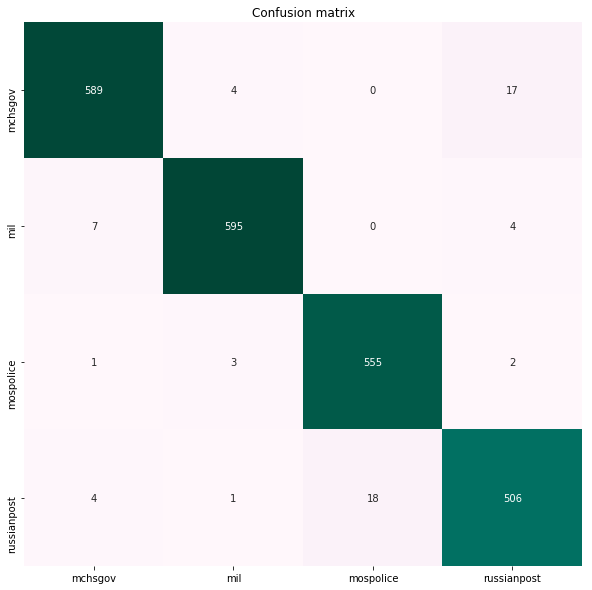

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(test.source, predictions_tfidf)

labels = clf_tfidf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

Итак, по оси OY у нас подписаны реальные классы, по OX - предсказанные. Мы видим, что всё определилось довольно точно, однако были некоторые ошибки: к russianpost относятся (506+18+1+4=529) групп, однако 18 из них были отнесены к mospolice; к mchsgov относятся (589+4+17=610) групп, но 17 из них были отнесены к russianpost. Если смотреть в общем, то мы получили, как и было нужно, явно выраженную "лесенку".

А теперь попробуем использовать SGD - стохастический градиентный спуск, оптимизационный алгоритм - в данном случае мы имеем дело с линейным классификатором (по дефолту - с линейным  SVM), который использует SGD для обучения.                 

In [115]:
clf_sgdc = Pipeline([
    ('vect', tfidf),
    ('clf', SGDClassifier()),
])

In [116]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)), 
    'clf__max_iter': (5,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
}

In [117]:
%time clf_sgdc.fit(train.text, train.source)

CPU times: user 11.2 s, sys: 290 ms, total: 11.5 s
Wall time: 11 s


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

In [118]:
predictions_sgdc = clf_sgdc.predict(test.text)

In [123]:
eval(test.source, predictions_sgdc)


Precision:   0.98
Recall:   0.98
F1-measure:   0.98
...
Precision:   0.98
Recall:   0.98
F1-measure:   0.98
...
Accuracy:   0.98


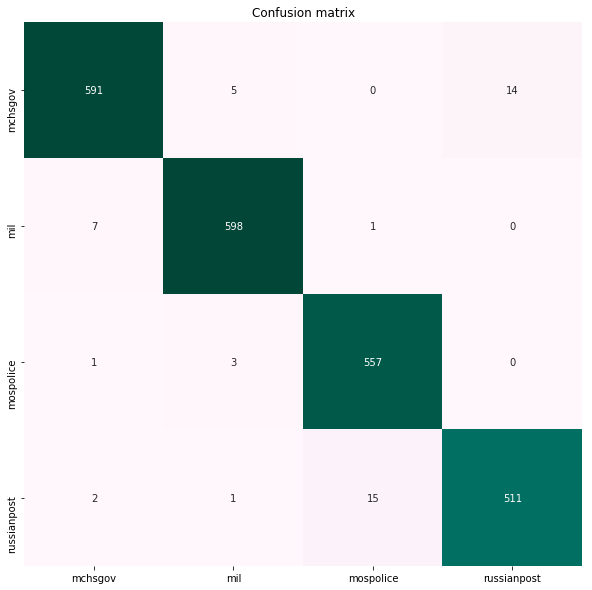

In [120]:
m = confusion_matrix(test.source, predictions_sgdc)

labels = clf_sgdc.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

И хотя те же самые небольшие проблемы остались (например, 15 групп russianpost были ошибочно отнесены к mospolice, 14 групп mchsgov - к russianpost), они стали еще меньше, а F1-мера подросла до 0.98 - оптимизационный алгоритм помог. 

### Задание 4: снижение размерности 

В качестве метода снижения размерности использует LSA (в sklearn'е он представлен TruncatedSVD). Необходимо помнить о том, что в LSA компоненты могут быть случайным образом как положительными, так и отрицательными - значит, нужно аккуратнее подходить к выбору классификатора (например, наивный байесовский классификатор не подойдёт, т.к. он не принимает на вход отрицательные значения). 

In [124]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=300, 
                         algorithm='randomized',
                         n_iter=10, random_state=42)

In [126]:
clf_lsa = Pipeline([
    ('vect', tfidf),
    ('svd', svd_model), 
    ('clf', LogisticRegression()),
])

# учим классификатор
%time clf_lsa.fit(train.text, train.source)

CPU times: user 48.6 s, sys: 2.73 s, total: 51.3 s
Wall time: 33.4 s


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [128]:
predictions_lsa = clf_lsa.predict(test.text)

In [129]:
eval(test.source, predictions_lsa)

Precision:   0.97
Recall:   0.97
F1-measure:   0.97
...
Precision:   0.97
Recall:   0.97
F1-measure:   0.97
...
Accuracy:   0.97


In [130]:
print(classification_report(test.source, predictions_lsa))

             precision    recall  f1-score   support

    mchsgov       0.98      0.96      0.97       610
        mil       0.99      0.98      0.98       606
  mospolice       0.97      0.99      0.98       561
russianpost       0.95      0.96      0.95       529

avg / total       0.97      0.97      0.97      2306



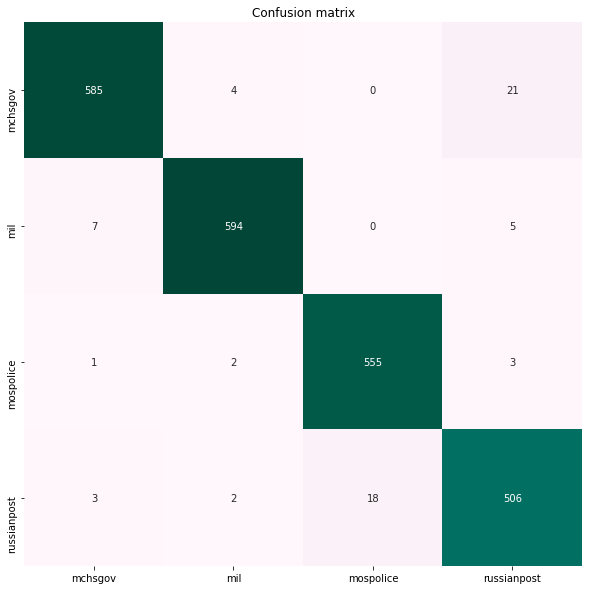

In [131]:
m = confusion_matrix(test.source, predictions_lsa)

labels = clf_sgdc.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

Мы видим, что улучшений по сравнению с baseline не наблюдается - наоборот, в некоторых случаях немного увеличилось количество неверно классифицированных групп (впрочем, совсем немного). То есть результаты практически не изменились после добавления такого шага, как снижение размерности. 

### Задание 5: лемматизация

Посмотрим, какой результат мы получим, если будем использовать лемматизированные тексты. 

In [136]:
def join(text):
    joint = ' '.join(text)
    return joint

Возьмём пайплайн из бейзлайна: там мы использовали CountVectorizer в сочетании с TfidfTransformer на униграммах и биграммах: 

In [138]:
%time clf_tfidf.fit(train.lemm_text.apply(join), train.source)

CPU times: user 13.9 s, sys: 419 ms, total: 14.3 s
Wall time: 10.8 s


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [139]:
predictions_lemm = clf_tfidf.predict(test.lemm_text.apply(join))

In [140]:
eval(test.source, predictions_lemm)

Precision:   0.97
Recall:   0.98
F1-measure:   0.97
...
Precision:   0.98
Recall:   0.98
F1-measure:   0.98
...
Accuracy:   0.98


In [141]:
print(classification_report(test.source, predictions_lemm))

             precision    recall  f1-score   support

    mchsgov       0.99      0.96      0.98       610
        mil       0.98      0.98      0.98       606
  mospolice       0.97      0.99      0.98       561
russianpost       0.96      0.96      0.96       529

avg / total       0.98      0.98      0.98      2306



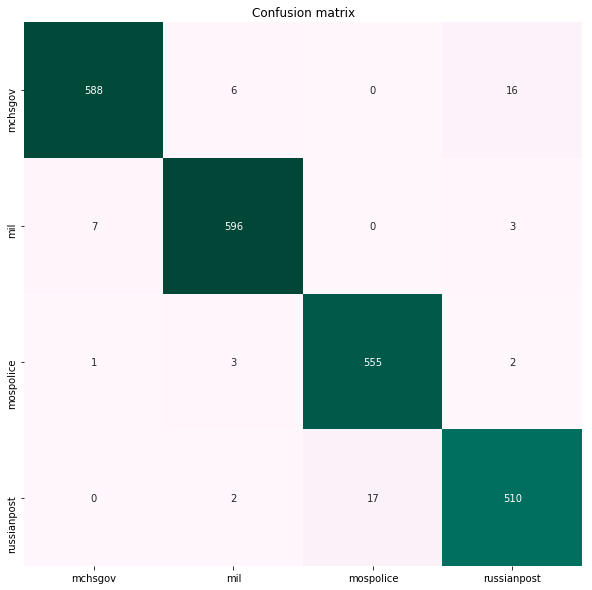

In [142]:
m = confusion_matrix(test.source, predictions_lemm)

labels = clf_sgdc.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

Как видим, использование лемматизированных слов не принесло ощутимых результатов (впрочем, классификация стало немного лучше - особенно для mchsgov).

А что если нам попробовать не просто взять леммы, а ещё и избавиться от шумовых слов?

In [143]:
from nltk.corpus import stopwords
stops = set(stopwords.words('russian'))

In [144]:
def stopwords_remove(text):
    
    without_stops = [word for word in text if word not in stops]
    
    return without_stops

In [153]:
%time clf_tfidf.fit(train.lemm_text.apply(stopwords_remove).apply(join), train.source)

CPU times: user 12.4 s, sys: 346 ms, total: 12.8 s
Wall time: 9.81 s


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [154]:
predictions_lemm_no_stops = clf_tfidf.predict(test.lemm_text.apply(stopwords_remove).apply(join))

In [155]:
eval(test.source, predictions_lemm_no_stops)

Precision:   0.98
Recall:   0.98
F1-measure:   0.98
...
Precision:   0.98
Recall:   0.98
F1-measure:   0.98
...
Accuracy:   0.98


In [156]:
print(classification_report(test.source, predictions_lemm_no_stops))

             precision    recall  f1-score   support

    mchsgov       0.98      0.96      0.97       610
        mil       0.98      0.99      0.99       606
  mospolice       0.97      0.99      0.98       561
russianpost       0.97      0.96      0.96       529

avg / total       0.98      0.98      0.98      2306



Ух ты, небольшое улучшение по всем классам.

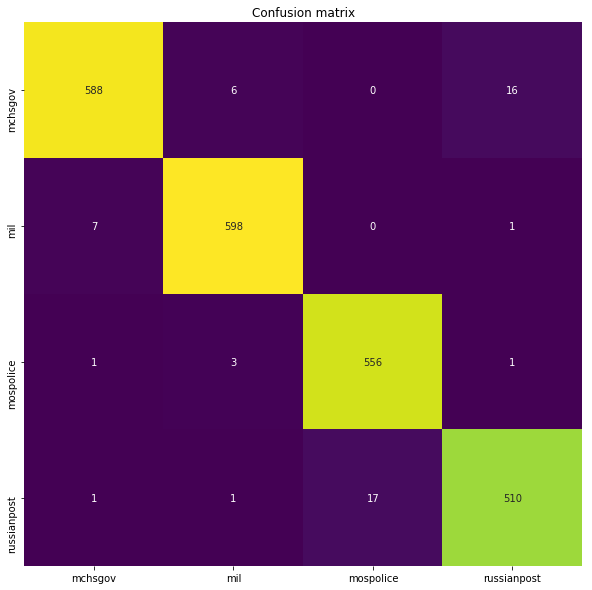

In [173]:
m = confusion_matrix(test.source, predictions_lemm_no_stops)

labels = clf_sgdc.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.title("Confusion matrix")
plt.show()

### Задание 6: модель скрытых тем

In [174]:
df['without_stops'] = [stopwords_remove(i) for i in df['lemm_text']]
df

,text,source,clean_text,symb_len,tok_text,len_in_words,lemm_text,pred_source,without_stops
666,В Хабаровском крае в рамках контрольной провер...,mil,В Хабаровском крае в рамках контрольной провер...,713,"[в, хабаровском, крае, в, рамках, контрольной,...",78,"[в, хабаровский, край, в, рамка, контрольный, ...",mil,"[хабаровский, край, рамка, контрольный, провер..."
9605,В Москве проходит операция «Нелегальный автобу...,mospolice,В Москве проходит операция «Нелегальный автобу...,2442,"[в, москве, проходит, операция, нелегальный, а...",271,"[в, москва, проходить, операция, нелегальный, ...",mospolice,"[москва, проходить, операция, нелегальный, авт..."
3031,#МЧС #МЧСРОССИИ<br><br>С 25 мая по 25 июля 201...,mchsgov,#МЧС #МЧСРОССИИ С 25 мая по 25 июля 2018 ввод...,220,"[мчс, мчсроссии, с, 25, мая, по, 25, июля, 201...",26,"[мчс, мчсроссия, с, 25, май, по, 25, июль, 201...",mchsgov,"[мчс, мчсроссия, 25, май, 25, июль, 2018, ввод..."
3813,#МЧС #МЧСРОССИИ<br><br>В Москве на улице Креме...,mchsgov,#МЧС #МЧСРОССИИ В Москве на улице Кременчугск...,205,"[мчс, мчсроссии, в, москве, на, улице, кременч...",20,"[мчс, мчсроссия, в, москва, на, улица, кременч...",mchsgov,"[мчс, мчсроссия, москва, улица, кременчугский,..."
1379,Танкисты Центрального военного округа на Чебар...,mil,Танкисты Центрального военного округа на Чебар...,478,"[танкисты, центрального, военного, округа, на,...",54,"[танкист, центральный, военный, округа, на, че...",mil,"[танкист, центральный, военный, округа, чебарк..."
11464,«МВД России сообщает о кураторстве подразделен...,mospolice,«МВД России сообщает о кураторстве подразделен...,569,"[мвд, россии, сообщает, о, кураторстве, подраз...",68,"[мвд, россия, сообщать, о, кураторство, подраз...",mospolice,"[мвд, россия, сообщать, кураторство, подраздел..."
7021,Спорт - это жизнь! Удмуртский филиал Почты Рос...,russianpost,Спорт - это жизнь! Удмуртский филиал Почты Рос...,815,"[спорт, это, жизнь, удмуртский, филиал, почты,...",109,"[спорт, это, жизнь, удмуртский, филиал, почта,...",russianpost,"[спорт, это, жизнь, удмуртский, филиал, почта,..."
134,Экипаж тяжелого вертолета Ми-26 в небе над Рос...,mil,Экипаж тяжелого вертолета Ми-26 в небе над Рос...,317,"[экипаж, тяжелого, вертолета, ми-26, в, небе, ...",39,"[экипаж, тяжёлый, вертолёт, ми-26, в, небо, на...",mil,"[экипаж, тяжёлый, вертолёт, ми-26, небо, росто..."
11301,Судом вынесено решение в отношении владельца э...,mospolice,Судом вынесено решение в отношении владельца э...,296,"[судом, вынесено, решение, в, отношении, владе...",31,"[суд, вынести, решение, в, отношение, владелец...",-,"[суд, вынести, решение, отношение, владелец, э..."
11158,Таксист задержан за ограбление пассажира<br><b...,mospolice,Таксист задержан за ограбление пассажира #МВ...,123,"[таксист, задержан, за, ограбление, пассажира,...",11,"[таксист, задержать, за, ограбление, пассажир,...",mospolice,"[таксист, задержать, ограбление, пассажир, мвд..."


Представляем данные в gensim словарём и корпусом

In [175]:
from gensim.corpora import *
from gensim.models import  *
from gensim import similarities


texts = [df.without_stops[i] for i in range(len(df))] # берем лемматизированные тексты без стоп-слов
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

Вычисляем сходства по косинусной мере на векторах tf-idf

In [176]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

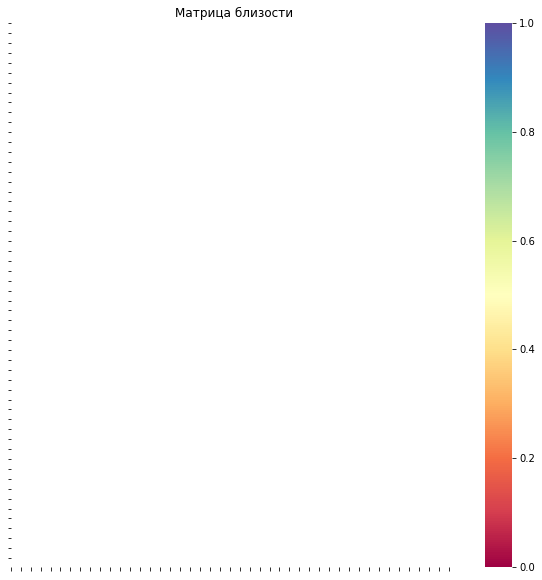

In [177]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])

plt.title("Матрица близости")
plt.show()

Белое поле. Зима близко. Кажется, слишком много данных - попробуем отрезать половину. 

In [196]:
df_s = df.sample(frac = 0.5)
df_s.reset_index(drop=True, inplace=True)

In [197]:
df_s.head()

,text,source,clean_text,symb_len,tok_text,len_in_words,lemm_text,pred_source,without_stops
0,УВД по Западному округу столицы посетила делег...,mospolice,УВД по Западному округу столицы посетила делег...,504,"[увд, по, западному, округу, столицы, посетила...",60,"[увд, по, западный, округа, столица, посетить,...",mospolice,"[увд, западный, округа, столица, посетить, дел..."
1,Третий день акции «Лучший рассказ о почтальоне...,russianpost,Третий день акции «Лучший рассказ о почтальоне...,2910,"[третий, день, акции, лучший, рассказ, о, почт...",416,"[три, день, акция, хороший, рассказ, о, почтал...",russianpost,"[день, акция, хороший, рассказ, почтальон, раз..."
2,Сотрудницы московской полиции утвердили уставн...,mospolice,Сотрудницы московской полиции утвердили уставн...,926,"[сотрудницы, московской, полиции, утвердили, у...",114,"[сотрудница, московский, полиция, утвердить, у...",mospolice,"[сотрудница, московский, полиция, утвердить, у..."
3,Подводный крейсер стратегического назначения п...,mil,Подводный крейсер стратегического назначения п...,122,"[подводный, крейсер, стратегического, назначен...",15,"[подводный, крейсер, стратегический, назначени...",mil,"[подводный, крейсер, стратегический, назначени..."
4,8 ноября 1772 года во время Русско-турецкой во...,mil,8 ноября 1772 года во время Русско-турецкой во...,426,"[8, ноября, 1772, года, во, время, русско-туре...",57,"[8, ноябрь, 1772, год, в, время, русско-турецк...",-,"[8, ноябрь, 1772, год, время, русско-турецкий,..."


In [179]:
texts = [df_s.without_stops[i] for i in range(len(df_s))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [180]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

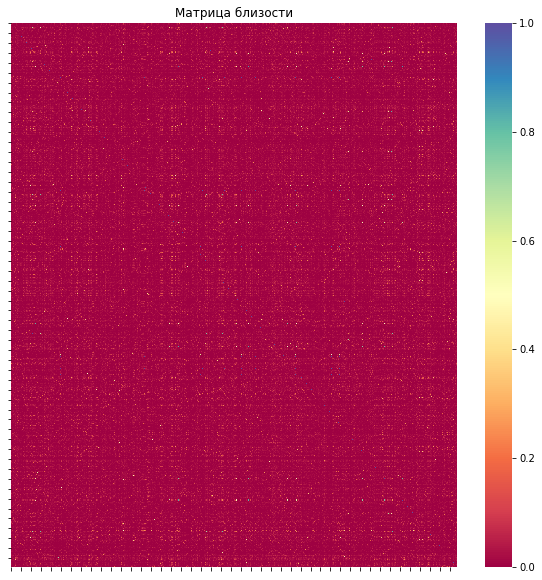

In [181]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])

plt.title("Матрица близости")
plt.show()

Почему у нас получился такой равномерный ковер без рисунка? Потому что наши тексты не отсортированы!

In [198]:
df_s = df_s.sort_values(['source'])

In [201]:
df_s.reset_index(drop=True, inplace=True)

In [202]:
texts = [df_s.without_stops[i] for i in range(len(df_s))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [203]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

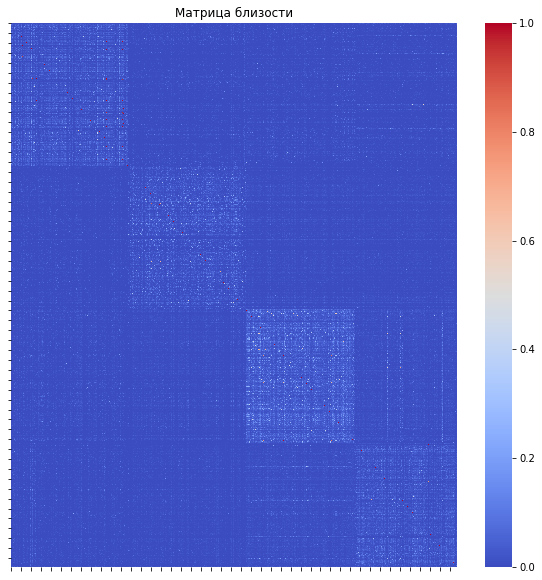

In [205]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = "coolwarm").set(xticklabels=[],yticklabels=[])

plt.title("Матрица близости")
plt.show()

Ну вот, теперь видные 'призраки' наших 4 групп. Теперь обратимся к латентно-семантическому анализу (LSI): 

In [206]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=4) # количество тем = 4

CPU times: user 11.3 s, sys: 510 ms, total: 11.8 s
Wall time: 7.74 s


In [208]:
lsi.show_topics(4)

[(0,
  '-0.227*"полиция" + -0.224*"мвд" + -0.181*"москва" + -0.172*"мчс" + -0.169*"год" + -0.141*"россия" + -0.138*"гу" + -0.138*"сотрудник" + -0.132*"мчсроссия" + -0.130*"петровка38"'),
 (1,
  '-0.499*"мчс" + -0.463*"мчсроссия" + -0.308*"безопасностьэтый" + -0.290*"беречь" + -0.242*"следовать" + -0.207*"правило" + -0.198*"безопасность" + -0.146*"фактмчс" + -0.117*"советмчс" + 0.116*"полиция"'),
 (2,
  '0.224*"безопасностьэтый" + 0.213*"беречь" + 0.176*"следовать" + 0.165*"мвд" + 0.156*"полиция" + -0.139*"почтовый" + 0.137*"правило" + -0.127*"почта" + 0.123*"петровка38" + 0.120*"задержать"'),
 (3,
  '0.363*"мчс" + -0.361*"безопасностьэтый" + -0.350*"беречь" + -0.302*"следовать" + 0.299*"мчсроссия" + -0.252*"правило" + 0.211*"фактмчс" + -0.204*"безопасность" + 0.153*"советмчс" + 0.133*"фото"')]

последняя тема (№3), по всей видимости, можно связать с mchsgov, первая тема (№0) - преимущественно mospolice с вкраплением mchsgov, вторая (№1) - наоборот, преимущественно mchsgov с вкраплением mospolice, третья (№2) - мешанина из разных тем. Результат неутешительный.

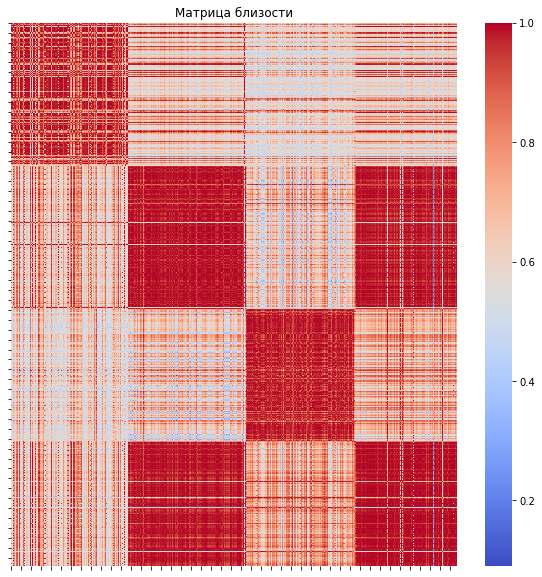

In [209]:
corpus_s_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_s_lsi]
sims  = (sims + 1)/2.
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = "coolwarm").set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

Мы видим, что группы выделились не так однозначно. 

LSI может применяться как с обучением, так и без обучения - так что разделение на обучающую и тестовую выборки необязательно. LSI полезен так в задачах классификации, так и в задачах кластеризации, т.к. позволяет извлечь контекстно-зависимые значения лексических единиц - и позволяет, например, справиться с проблемой омонимии (когда одно и то же слово с разными значениями принадлежит разным темам, классам). И, конечно, LSI не так однозначен, он показывает степень схожести/различия элементов/групп документов (документы, использующие похожие слова, и слова, встречающиеся в схожем наборе документов группируются -> эти группы и составляют скрытые темы). Модель скрытых тем может быть особенна полезна при кластеризации, когда у нас нет готовых лейблов/классов, но мы хотим их выделить на основании имеющихся данных (наиболее естественно; при этом можно сравнить результаты с алгоритмами классификации с обучением). Возможно, LSI позволяет выявить 'проблемные места' при классификации, где нужно постараться чётко определить дискриминативные признаки, а также  может 'добавить' ключевых слов для определения классов. 

### Задание 7: CBOW

Возьмём word2vec - и посмотрим, поможет ли он улучшить классификацию. Разделим данные:

In [250]:
df = shuffle(df)

train, test = train_test_split(df, test_size=0.2)
train.tail()

,text,source,clean_text,symb_len,tok_text,len_in_words,lemm_text,pred_source,without_stops
10488,Московские полицейские пресекли мошенническую ...,mospolice,Московские полицейские пресекли мошенническую ...,441,"[московские, полицейские, пресекли, мошенничес...",49,"[московский, полицейский, пресечь, мошенническ...",mospolice,"[московский, полицейский, пресечь, мошенническ..."
9030,Столичные полицейские задержали подозреваемого...,mospolice,Столичные полицейские задержали подозреваемого...,213,"[столичные, полицейские, задержали, подозревае...",20,"[столичный, полицейский, задержать, подозреват...",mospolice,"[столичный, полицейский, задержать, подозреват..."
6973,"Дорогие друзья, сегодня День России! 42 000 по...",russianpost,"Дорогие друзья, сегодня День России! 42 000 по...",496,"[дорогие, друзья, сегодня, день, россии, 42, 0...",70,"[дорогой, друг, сегодня, день, россия, 42, 000...",russianpost,"[дорогой, друг, сегодня, день, россия, 42, 000..."
5262,#ФактМЧС,mchsgov,#ФактМЧС,8,[фактмчс],1,[фактмчс],-,[фактмчс]
10604,Полицейские Восточного округа Москвы присоедин...,mospolice,Полицейские Восточного округа Москвы присоедин...,774,"[полицейские, восточного, округа, москвы, прис...",99,"[полицейский, восточный, округа, москва, присо...",mospolice,"[полицейский, восточный, округа, москва, присо..."


In [251]:
data = train['without_stops']

Получаем эмбеддинги - тренируем модель word2vec

In [252]:
import gensim

model = gensim.models.Word2Vec(data, size=100)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


Теперь у нас есть словарь вида 'слово-вектор размерности 100' - посмотрим, например, вектор слова 'россия':

In [253]:
w2v['россия']

array([-0.2670694 ,  0.8868794 , -0.85330826,  1.7094067 , -0.1891521 ,
        1.1283876 , -0.54600066,  0.65761787,  0.45656845,  0.26547074,
       -1.7797409 , -1.0739675 , -0.5891636 ,  1.1832008 , -0.51902944,
       -1.3468255 , -0.38665134, -0.13144188, -0.04626187,  0.79214126,
        0.02500338, -0.44880295,  0.81625736,  0.22578067, -0.3562516 ,
        0.45852607,  0.9600376 ,  1.4770133 ,  1.8895129 ,  0.65778923,
       -0.5017037 ,  2.0682688 , -0.80916846, -1.107747  ,  1.3550196 ,
       -0.16483831,  0.80478704, -0.27753043, -2.014703  ,  0.00449199,
        0.94516397,  0.80470234,  1.1008458 ,  1.2210227 ,  2.4275465 ,
        0.1047782 , -1.9737583 ,  1.2413874 , -1.7267555 ,  1.3156788 ,
        0.18046446,  0.8380706 , -0.45346987,  0.90247756,  0.4333087 ,
        0.5019884 ,  0.5449801 ,  0.65341526,  0.595106  , -0.50312746,
       -1.9888461 , -0.9617948 , -0.26965392,  1.4105332 ,  1.4173306 ,
       -1.3469069 ,  1.0441691 ,  0.4492414 , -0.5953735 ,  1.34

Теперь строим трансформер, совместимый со sklearn'ом - и инициализирующийся нашим словарём 'слово-вектор'. Получаем фичи: усредняем все вектора слов для каждого текста

In [254]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(w2v))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

Добавим также версию с tf-idf-взвешиванием

In [267]:
from collections import Counter, defaultdict


class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(w2v))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # idf по дефолту - максимальный из изветсных idf (ведь слово может быть неизвестно)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

Теперь можем работать с ними, почти как с CountVectorizer и TfidfVectorizer. Используем пайплайн sklearn'а ExtraTrees:

In [268]:
from sklearn.ensemble import ExtraTreesClassifier

etree_w2v = Pipeline([("w2v vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [269]:
%time etree_w2v.fit(train.without_stops, train.source)

predictions_w2v = etree_w2v.predict(test.without_stops)

CPU times: user 11.1 s, sys: 76.1 ms, total: 11.2 s
Wall time: 11.3 s


In [259]:
eval(test.source, predictions_w2v)

Precision:   0.97
Recall:   0.97
F1-measure:   0.97
...
Precision:   0.97
Recall:   0.97
F1-measure:   0.97
...
Accuracy:   0.97


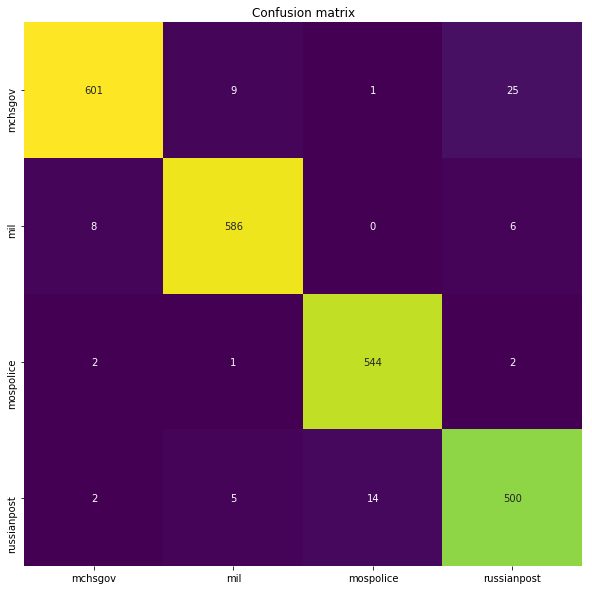

In [275]:
m = confusion_matrix(test.source, predictions_w2v)

labels = clf_sgdc.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.title("Confusion matrix")
plt.show()

Как видим, результат не превзошёл baseline - и те же проблемы с russianpost (14 групп отнесено к mospolice) и с mchsgov (25 групп ошибочно отнесено к russianpost).

Теперь проверим версию с tf-idf взвешиванием:

In [270]:
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [271]:
%time etree_w2v_tfidf.fit(train.without_stops, train.source)


CPU times: user 58.7 s, sys: 881 ms, total: 59.6 s
Wall time: 1min


Pipeline(memory=None,
     steps=[('word2vec vectorizer', <__main__.TfidfEmbeddingVectorizer object at 0x1164f4390>), ('extra trees', ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurit...imators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [272]:
predictions_w2v_tfidf = etree_w2v_tfidf.predict(test.without_stops)

In [273]:
eval(test.source, predictions_w2v_tfidf)

Precision:   0.96
Recall:   0.97
F1-measure:   0.96
...
Precision:   0.96
Recall:   0.96
F1-measure:   0.96
...
Accuracy:   0.96


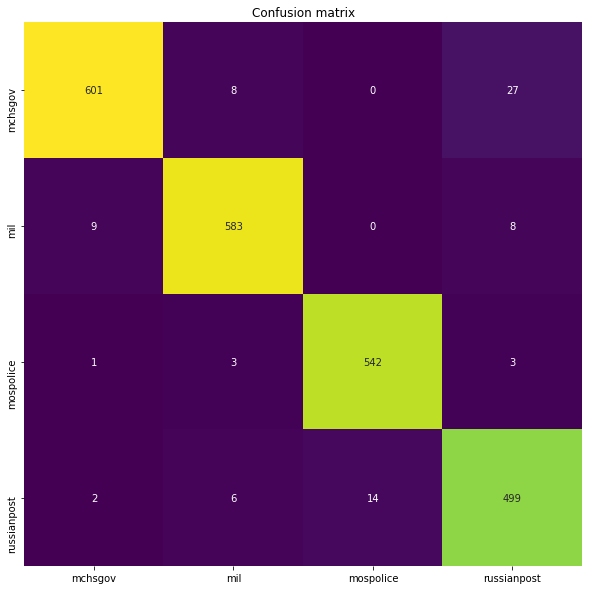

In [276]:
m = confusion_matrix(test.source, predictions_w2v_tfidf)

labels = clf_sgdc.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.title("Confusion matrix")
plt.show()

Всё то же самое, только немного хуже (на 0.1)

### Fin

Самыми успешными оказались:

- пайплайн с TfidfVectorizer и оптимизационным алгоритм SGD (линейный классификатор, который использует SGD для обучения): F1-score 0.98
- пайплайн с TfidfVectorizer и логистической регрессией на лемматизированных текстах, в которых были удалены стоп-слова: F1-score 0.98

Итак, baseline был побит, однако не самый изощрённым соперником. Модель скрытых тем в нашем случае пользы не принесла (скажем, четыре группы не удалось выделить каким-то вразумительным образом). Эмбеддинги тоже не улучшили результат (а усреднение эмбеддингов слов с tf-idf весами вообще ухудшило результат на 0.1), как и LSA. Правила, работающие безотказно, придумать не удалось: в текстах, безусловно есть общие слова, которые для одной из тем могут иметь классифицирующий потенциал (например, 'отделение' - это может быть и почтовое отделение, и отделение полиции). В общем, в данном случае сработали довольно простые методы.